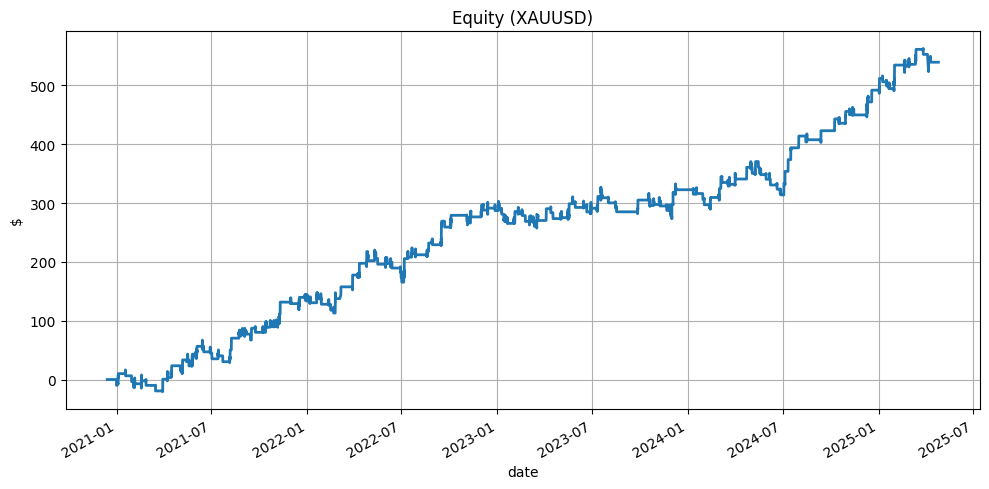


Profit/Trade 2.78 Mean: 183.0 Stdev 91.0 Sharpe 2.01


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

# parameters
file, dt, dh, tp, sl = "XAUUSD_5min.csv.gz", 720, 20.0, 20.0, 10.0

# read data
df = pd.read_csv(file, index_col='date', parse_dates=['date'])
low, high, close = df[['low','high','close']].to_numpy().T

# compute long candidates (after val_candl the candidate is no longer valid)
candl = np.array([i for i in argrelextrema(high, np.greater, order=dt)[0] if dt <= i < len(high) - dt and high[i] - low[i-dt:i+1].min() >= dh and high[i] - low[i:i+dt+1].min() >= dh])
val_candl = np.array([i + 1 + np.argmax(high[i+1:] > high[i]) if np.any(high[i+1:] > high[i]) else np.inf for i in candl])

# compute short candidates (after val_cands the candidate is no longer valid)
cands = np.array([i for i in argrelextrema(low, np.less, order=dt)[0] if dt <= i < len(low) - dt and high[i-dt:i+1].max() - low[i] >= dh and high[i:i+dt+1].max() - low[i] >= dh])
val_cands = np.array([i + 1 + np.argmax(low[i+1:] < low[i]) if np.any(low[i+1:] < low[i]) else np.inf for i in cands])

# backtest
equity    = np.zeros(len(df))
n = cumulBuy  = cumulSell = 0.0
entryBuy  = stopBuy = slBuy = tpBuy = 0
entrySell = stopSell = slSell = tpSell = 0
for tc, (h, l, c) in enumerate(zip(high, low, close)):

    # BUY management
    if entryBuy:
        if   l < slBuy:           cumulBuy += slBuy - entryBuy; entryBuy = 0
        elif h > tpBuy:           cumulBuy += tp;               entryBuy = 0
        elif c > slBuy + sl:      slBuy     = c - sl
    elif stopBuy and h > stopBuy:
        n, entryBuy, slBuy, tpBuy, stopBuy = n+1, stopBuy, stopBuy - sl, stopBuy + tp, 0

    # SELL management
    if entrySell:
        if   h > slSell:          cumulSell -= slSell - entrySell; entrySell = 0
        elif l < tpSell:          cumulSell += tp;                 entrySell = 0
        elif c < slSell - sl:     slSell    = c + sl
    elif stopSell and l < stopSell:
        n, entrySell, slSell, tpSell, stopSell = n+1, stopSell, stopSell + sl, stopSell - tp, 0

    # update equity
    equity[tc] = cumulBuy + np.sign(entryBuy) * (c - entryBuy) + cumulSell + np.sign(entrySell) * (entrySell - c)

    # recompute stops
    ml, ms = (candl < tc - dt) & (tc < val_candl), (cands < tc - dt) & (tc < val_cands)
    if ml.any(): stopBuy = high[candl[ml]].min()
    if ms.any(): stopSell = low[cands[ms]].max()

# Plot
pd.Series(equity, index=df.index, name='equity').plot(title='Equity (XAUUSD)', ylabel='$', grid=True, linewidth=2, figsize=(10, 5))
plt.tight_layout()
plt.show()

# Statistics
print()
r = np.diff(equity)
m, s = 288*365*r.mean(), np.sqrt(288*365)*r.std()  # Annual mean and sigma
print("Profit/Trade", round(equity[-1]/n,2), "Mean:", round(m, 2), "Stdev", round(s, 2), "Sharpe", round(m/s, 2))
